In [1]:
import sys
sys.path.insert(0, './src/yelp_prediction')

In [2]:
import polars as pl
import dataframes as df
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

In [3]:
(df_restaurants, df_reviews, df_photos_by_business, df_features) = pl.collect_all(
    (
        df.q_restaurants,
        df.q_reviews,
        df.q_photos_agg,
        df.q_features,
    )
)

In [4]:
def run(f):
    # see https://peps.python.org/pep-0318/
    """Simple function that can be used as @decorator so that we don't pollute scopes"""
    out = f()
    if out is not None:
      display(out)

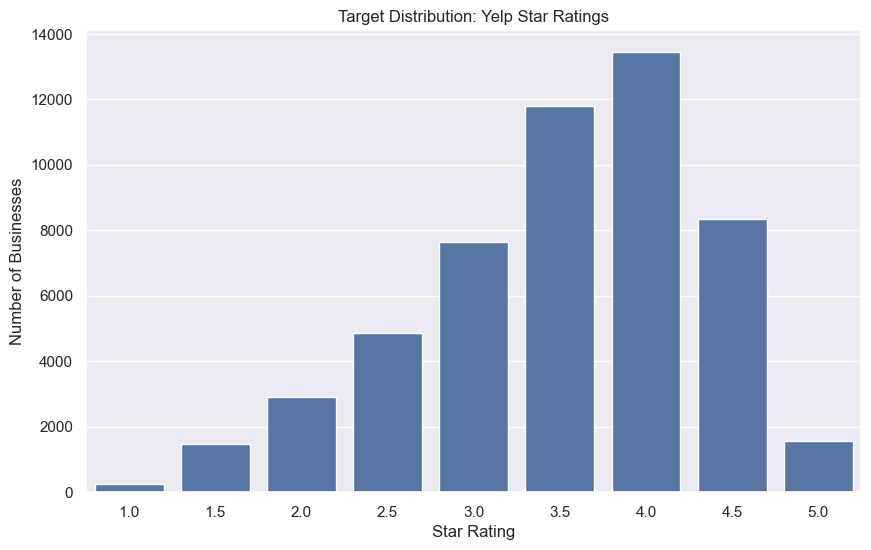

In [5]:

@run
def _show_stars_dist():
    stars_dist = df_restaurants.group_by("stars").len().sort("stars")
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=stars_dist["stars"],
        y=stars_dist["len"],
    )
    plt.title("Target Distribution: Yelp Star Ratings")
    plt.xlabel("Star Rating")
    plt.ylabel("Number of Businesses")

Pearson Correlation: 0.1658
Spearman Correlation: 0.2182


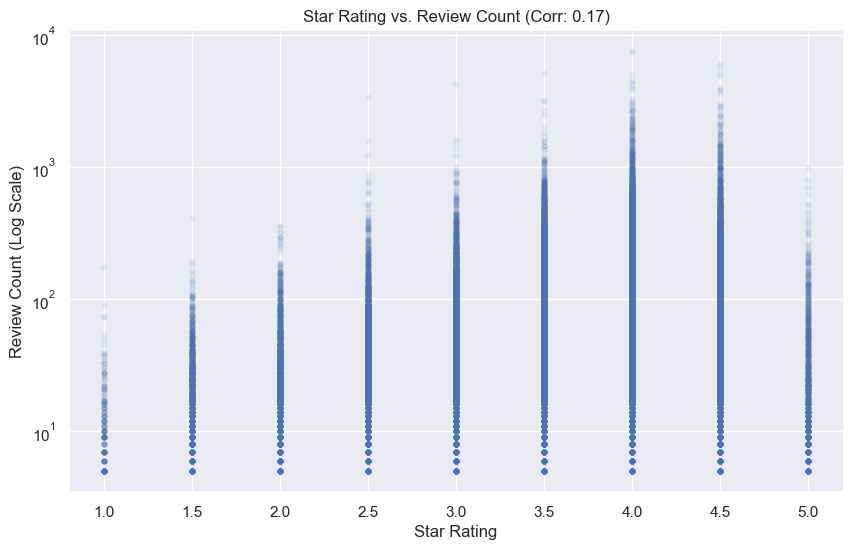

In [6]:
@run
def _show_correlation():
    corr_pearson = df_features.select(  #
        pl.corr("stars", "review_count", method="pearson")
    ).item()
    corr_spearman = df_features.select(
        pl.corr("stars", "review_count", method="spearman")
    ).item()
    print(f"Pearson Correlation: {corr_pearson:.4f}")
    print(f"Spearman Correlation: {corr_spearman:.4f}")

    plt.figure(figsize=(10, 6))

    # 2. Use sns.scatterplot
    # Note: If passing the whole dataframe is strictly required, use df.to_pandas()
    # But passing Polars Series as x/y usually works as they act like arrays.
    sns.scatterplot(
        x=df_restaurants["stars"],
        y=df_restaurants["review_count"],
        alpha=0.1,
        s=15,
        edgecolor=None,  # distinct from matplotlib: removes point borders for cleaner look
    )

    # 3. Matplotlib commands still control the Axes
    plt.yscale("log") 
    plt.title(f"Star Rating vs. Review Count (Corr: {corr_pearson:.2f})")
    plt.xlabel("Star Rating")
    plt.ylabel("Review Count (Log Scale)")

In [7]:
df_restaurants_with_photos = df_restaurants.join(
    df_photos_by_business,
    on="business_id",
    how="left",
).select(
    pl.col("business_id"),
    pl.col("stars"),
    pl.col("review_count"),
    pl.col("photo_count").fill_null(0),
)

In [8]:
@run
def _check_photo_bias():
    return df_restaurants_with_photos.group_by(
        (pl.col("photo_count") > 0).alias("has_photo")
    ).agg(
        [
            pl.len().alias("count"),
            pl.col("stars").mean().alias("avg_rating"),
            pl.col("stars").median().alias("median_rating"),
            pl.col("stars").std().alias("std"),
        ]
    )

has_photo,count,avg_rating,median_rating,std
bool,u32,f64,f64,f64
false,22894,3.376103,3.5,0.864702
true,29374,3.623562,4.0,0.78426


Correlation (Stars vs Photos): 0.1349


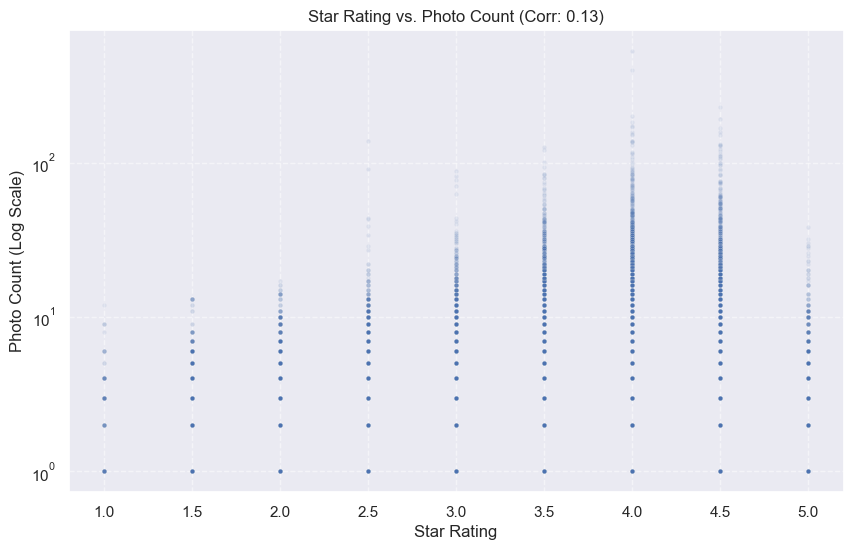

In [9]:
@run
def _show_photo_correlation():
    # Calculate Correlation
    corr = df_restaurants_with_photos.select(pl.corr("stars", "photo_count")).item()

    print(f"Correlation (Stars vs Photos): {corr:.4f}")

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=df_restaurants_with_photos["stars"].to_list(),
        y=df_restaurants_with_photos["photo_count"].to_list(),
        alpha=0.1,
        s=10,
    )

    plt.yscale("log")
    plt.title(f"Star Rating vs. Photo Count (Corr: {corr:.2f})")
    plt.xlabel("Star Rating")
    plt.ylabel("Photo Count (Log Scale)")

    plt.grid(True, linestyle="--", alpha=0.5)